In [20]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd

#dessa paket behöver installeras för att kunna testa dataanalysen

#här plottas k_värden och samma typer av massor

def read_tsv_1(file_path):
    """
    Denna funktion tar in "filepath" som är vägen till en fil som input och gör sedan om data till numpy listor, i detta fallet är det tsv.filer som läses in och datan börjar på tolfte raden
    Det antas också att det är ett objekts som har mätts, om det skulle vara två objekt se funktionen "read_tsv_2(filepath)"

    """
    df = pd.read_csv(file_path,  
                    sep='\t',          
                    skiprows=11,       
                    names=['index', 'time', 'x', 'y', 'z'])  

    
    t = df['time'].to_numpy()
    z = df['z'].to_numpy()
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    return t,z,x,y

def read_tsv_2(file_path):
    """
    Denna funktion tar in (filepath) som är vägen till en fil som input och ger sedan tillbaka två numpy listor som output. Denna funktion är skapad för att läsa in en fil som mätt två objekt och bara ge tillbaka x-koordinaterna
    """
    df = pd.read_csv(file_path,  
                    sep='\t',          
                    skiprows=11,       
                    names=['index', 'time', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2'])  

    # Display the first few rows to verify
    
    t = df['time'].to_numpy()
    x1 = df["x1"].to_numpy()
    x2 = df["x2"].to_numpy()
    
    return t, x1, x2

def fft(data, fs):
    """
    Denna funktion utför fast Fourier transform på en datamängd och tar in två inputs. (data) är den listan som ska Fouriertransformeras och (fs) är kamerans samplingsfrekvens.
    Funktionen returnerar amplituder för respektive frekvens i Fouriertransformen
    """

    window = np.hanning(len(data)) #Denna funktion används för att minimera diskontinuetit i datan för fast Fourier transformen
    windowed_data = data*window
    fft_values = np.fft.fft(windowed_data)
    window = np.hanning(len(data))
    windowed_data = data * window

    # Utför Fouriertransformen
    fft_values = np.fft.fft(windowed_data)
    frequencies = np.fft.fftfreq(len(data), d=1/fs)

    # Hämta endast positiva frekvenser (speglingen)
    positive_freq_indices = np.where(frequencies > 0.3)
    frequencies = frequencies[positive_freq_indices]
    fft_magnitude = np.abs(fft_values[positive_freq_indices])
    return frequencies, fft_magnitude

def max_f(f, a):
    """
    Denna funktion tar in två inputs "f" och "a", där "f" är frekvenserna som analyseras i fast Fourier transformationen och a är amplituden för dessa frekvenser. Funktionen returnerar sedan den frekvens som motsvarar högst amplitud.
    """
    max_index = np.argmax(a)
    return f[max_index]

def filter(t, z, t1, t2):
    """
    Denna funktion tar in fyra outputs där t och x är två numpy listor och t1 och t2 är något tidsintervall. Funktionen filtrerar t-listan mellan de två intervallen och tar sedam ut dessa värden i z-listan.
    """
    t3 = np.where((t >= t1) & (t <= t2))[0]
    return t[t3], z[t3]

def max_2(f, a):
    """
    Denna funktion tar in två inputs "f" och "a", där "f" är frekvenserna som analyseras i fast Fourier transformationen och a är amplituden för dessa frekvenser. Funktionen returnerar sedan de två frekvenserna som motsvarar två lokala maximum i amplitud-listan.
    """
    peaks, _ = find_peaks(a)
    top_two_indices = peaks[np.argsort(a[peaks])[-2:]]
    f_max = f[top_two_indices]
    return f_max

def maxA(a): #tror ej denna används
    peaks, _ = find_peaks(a)
    top_two_peaks = peaks[np.argsort(a[peaks])[-2:]]
    max2 = a[top_two_peaks]
    return max2


def real_amplitude(amplitudes, N):
    """
    Funktionen tar in tå parametrar en lista över amplituder och hur många datapunkter det är i lista. Funktionen ger sedan tillbaka de fysikalsika amplituderna.
    """
    korrekta_amplituder = (2.0 * amplitudes / N) 
    
    return korrekta_amplituder




In [21]:
def plot_k(file_path, tn, tu, m):
    """
    Funktionen tar in tre parametrar, en väg till en fil "filepath", ett tidsintervall som man vill analysera data mellan "tn" och "tu", och massan som används i systemet. Denna funktion är skapad för att ta reda på k-värden
    genom att analysera en svängningsrörelse för en vikt i en fjäder. Funktionen plottar z-koordinaten för massan över tiden och dess fouriertransform. Den printer även ut frekvensen som systemet motsvarar samt vad k-värdet
    bör vara enligt mätningen.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    t, z, x, y = read_tsv_1(file_path)
    t, z = filter(t, z, tn, tu)
    f, a = fft(z, 100)
    A = real_amplitude(a, len(a))
    #print(max(A))

    axs[0].plot(t, z) 
    axs[0].set_xlabel('Tid (s)', fontsize="18")
    axs[0].set_ylabel('Pendelns Position (mm)', fontsize="18")

    axs[0].set_title("Pendelns Position Över Tid", fontsize="18")
    axs[0].set_ylim(500, 700)

    axs[1].plot(f, A)
    axs[1].set_xlim(0, 5)
    axs[1].set_xlabel('Frekvens (Hz)', fontsize="18")
    axs[1].set_ylabel('Amplitud', fontsize="18")
    #axs[1].legend(loc='upper right')
    axs[1].set_title("Amplitud vs Frekvens", fontsize="18")

    fu = max_f(f, A)
    k = ((fu * 2 *np.pi)**2) * m
    print("Uppmätt frekvens: {}".format(fu))
    print("Uppmätt k-värde: {}".format(k))

def plot_2(file_path, tn, tu, m, L, k = 8.9, lcm = None):
    """
    Funktionen tar in sex parametrar. en väg till en fil "filepath", ett tidsintervall som man vill analysera data mellan "tn" och "tu", massan för de två vikter som användes "m", avståndet mellan krok i pendel och reflextejparna på massan "L", k-värdet
    för fjädern "k" som oftast var 8.9 då fjäder 3 användes mycket och lcm som är längden till masscentrum för pendlarna (lcm) som oftast var sammam som L.
    Funktionen gör sedan en Fouriertransform för vinkllarna för pendelns snöre och printar ut de dominerande frekvenserna. Diverse plotter över vinklarnas värde över tid och amplituderna mot frekvenserna görs även. Dessutom räknas de teoretiska frekvenserna ut.
    """

    if lcm is None:  # Om lcm inte ges som argument, sätt lcm = L, alltså att masscentrum är där reflextejpen sitter
        lcm = L

    fig, axs = plt.subplots(2, 2, figsize=(12, 5))
    t, x1, x2 = read_tsv_2(file_path)
    x1v = x1 - x1[0]
    x2v = x2 - x2[0]
    t1 = t.copy()
    t, x1v= filter(t, x1v, tn, tu)
    t2, x2v= filter(t1, x2v, tn, tu)
    theta1 = np.arcsin(x1v/L)
    theta2 = np.arcsin(x2v/L)
    f1, a1 = fft(theta1, 100)
    f2, a2 = fft(theta2, 100)

    A1 = real_amplitude(a1, len(a1))
    A2 = real_amplitude(a2, len(a2))
    
    
    print("Dominerande frekvenser v1 {}".format(max_2(f1, A2)))
    print("Dominerande frekvenser v2 {}".format(max_2(f2, A2)))
    print("Dominerande amplituder {}".format(maxA(A1)))

    teo1 = np.sqrt(9.82*1000/lcm) / (2*np.pi)
    teo2 = np.sqrt(9.82*1000/lcm + 2*k/m) / (2*np.pi)

    print("Teoretiska frekvenser {} {}".format(teo1, teo2))

    axs[0,0].plot(t, theta1, label=r"$\theta_1$")
    axs[0,0].set_xlabel('Tid (s)', fontsize="18")
    axs[0,0].set_ylabel('Pendelns Vinkel (rad)', fontsize="14")
    axs[0,0].legend(loc='upper right')
    axs[0,0].set_title("Pendelns Position Över Tid", fontsize="18")
    
    # Andra plotten: Frekvens vs Amplitud (Theta1)
    axs[0,1].plot(f1, A1, label=r"$\theta_1$")
    axs[0,1].set_xlabel('Frekvens (Hz)', fontsize="18")
    axs[0,1].set_ylabel('Amplitud', fontsize="18")
    axs[0,1].legend(loc='upper right')
    axs[0,1].set_title("Amplitud vs Frekvens", fontsize="18")
    axs[0,1].set_xlim(0, 2)
    
    # Tredje plotten: Tid vs Position (Theta2)
    axs[1,0].plot(t2, theta2, label=r"$\theta_2$", color="orange")
    axs[1,0].set_xlabel('Tid (s)', fontsize="18")
    axs[1,0].set_ylabel('Pendelns Vinkel (rad)', fontsize="14")
    axs[1,0].legend(loc='upper right')
    #axs[1,0].set_title("Andra pendelns vinkel över tid")
    
    # Fjärde plotten: Frekvens vs Amplitud (Theta2)
    axs[1,1].plot(f2, A2, label=r"$\theta_2$", color="orange")
    axs[1,1].set_xlabel('Frekvens (Hz)', fontsize="18")
    axs[1,1].set_ylabel('Amplitud', fontsize="18")
    axs[1,1].legend(loc='upper right')
    #axs[1,1].set_title("Amplitud vs Frekvens")
    axs[1,1].set_xlim(0, 2)
    
    plt.tight_layout()
    plt.show()
    


Uppmätt frekvens: 1.0494752623688155
Uppmätt k-värde: 8.900655491526791


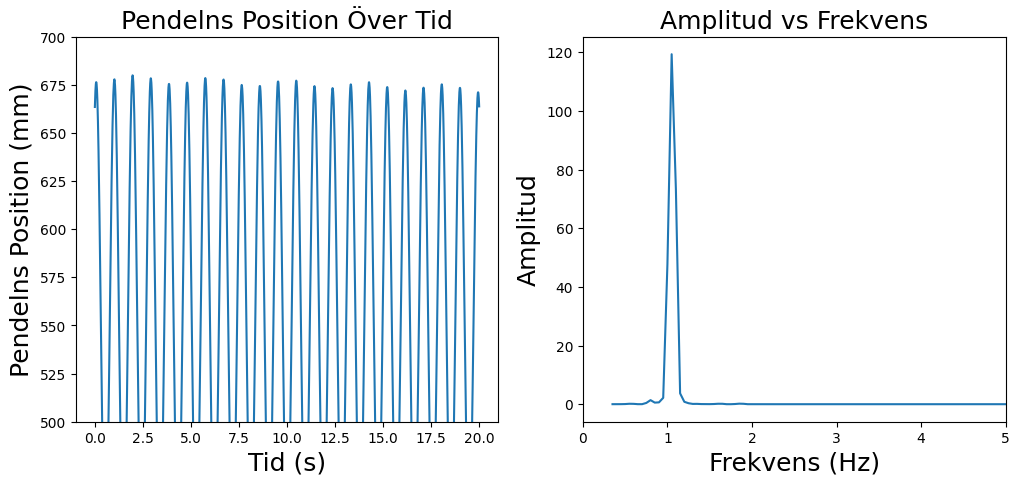

In [22]:
plot_k("FJ3_mätning_använd/FJ3_tisdag_1.tsv", 0, 20, 0.2047) #orginell

Uppmätt frekvens: 1.249375312343828
Uppmätt k-värde: 12.61430766939738


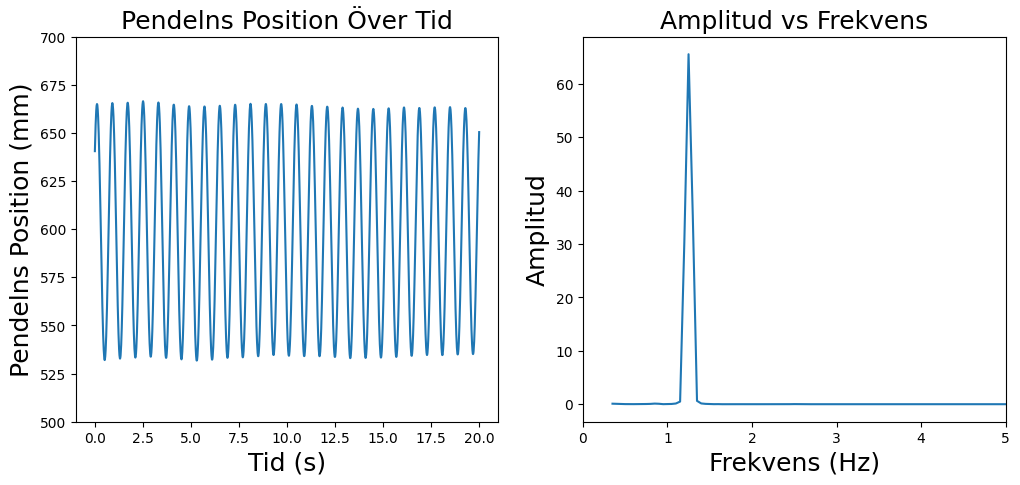

In [23]:
plot_k("FJ4_mätning_använd/FJ4_tisdag_1.tsv", 0, 20, 0.2047) #orginell

Dominerande frekvenser v1 [0.99971437 0.79977149]
Dominerande frekvenser v2 [0.99971437 0.79977149]
Dominerande amplituder [0.05052645 0.06536458]
Teoretiska frekvenser 0.8090662354024306 1.0482386179084273


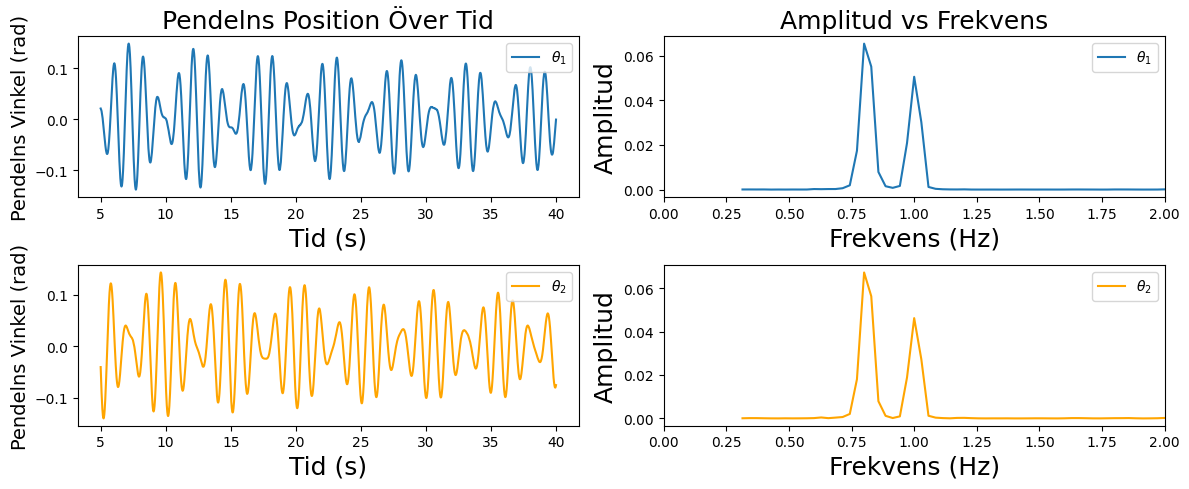

In [24]:
#massa 1.015 identiska, l=380 startade en pendel från typ
plot_2("KF_FJ3_M12_1.tsv",5, 40, 1.015, 380)

Dominerande frekvenser v1 [0.99960016 0.79968013]
Dominerande frekvenser v2 [0.99960016 0.79968013]
Dominerande amplituder [0.04742119 0.05965315]
Teoretiska frekvenser 0.8090662354024306 1.0482386179084273


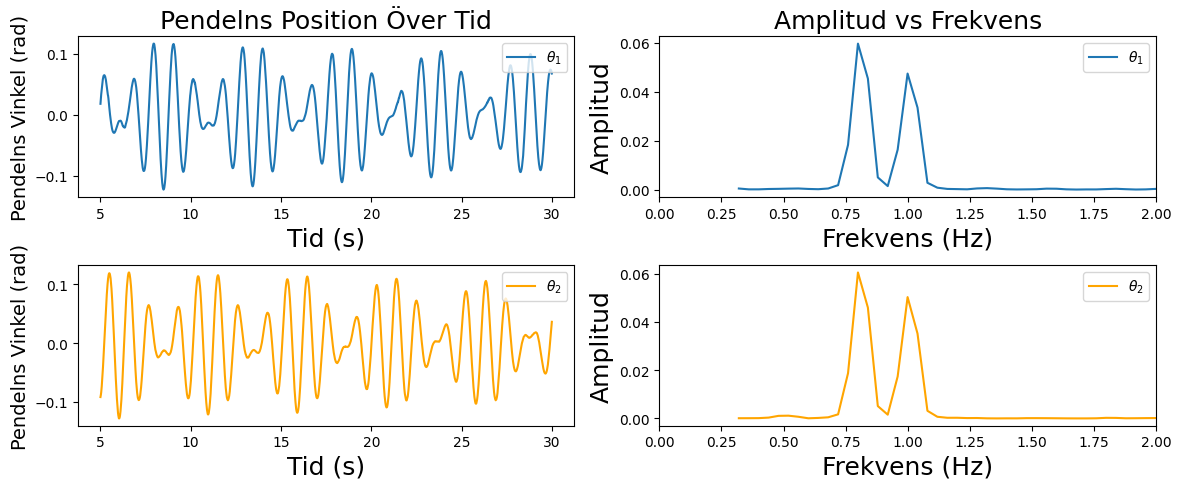

In [25]:
#massa 1.015 identiska, l=380 startade en pendel från en vinkel
plot_2("KS_Fj3_M12_4.tsv",5, 30, 1.015, 380)

Dominerande frekvenser v1 [0.99960016 0.79968013]
Dominerande frekvenser v2 [0.99960016 0.79968013]
Dominerande amplituder [0.00602229 0.14937263]
Teoretiska frekvenser 0.8090662354024306 1.0482386179084273


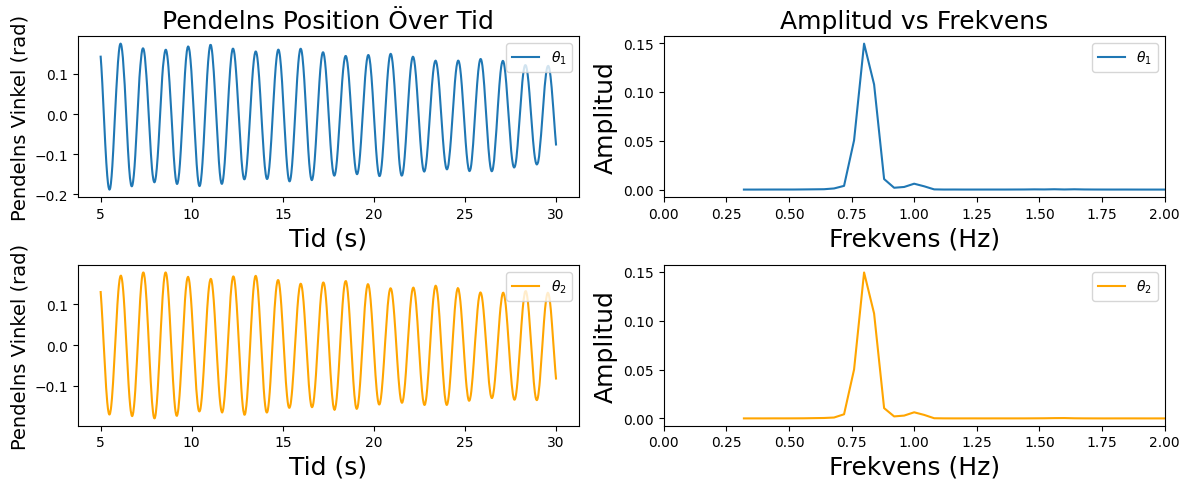

In [26]:
#massa 1.015 identiska, l=380 startade pendlar från samma vinklar
plot_2("KF_medsvängning_m12.tsv",5, 30, 1.015, 380)

Dominerande frekvenser v1 [0.79968013 0.99960016]
Dominerande frekvenser v2 [0.79968013 0.99960016]
Dominerande amplituder [0.00898341 0.04502097]
Teoretiska frekvenser 0.8090662354024306 1.0482386179084273


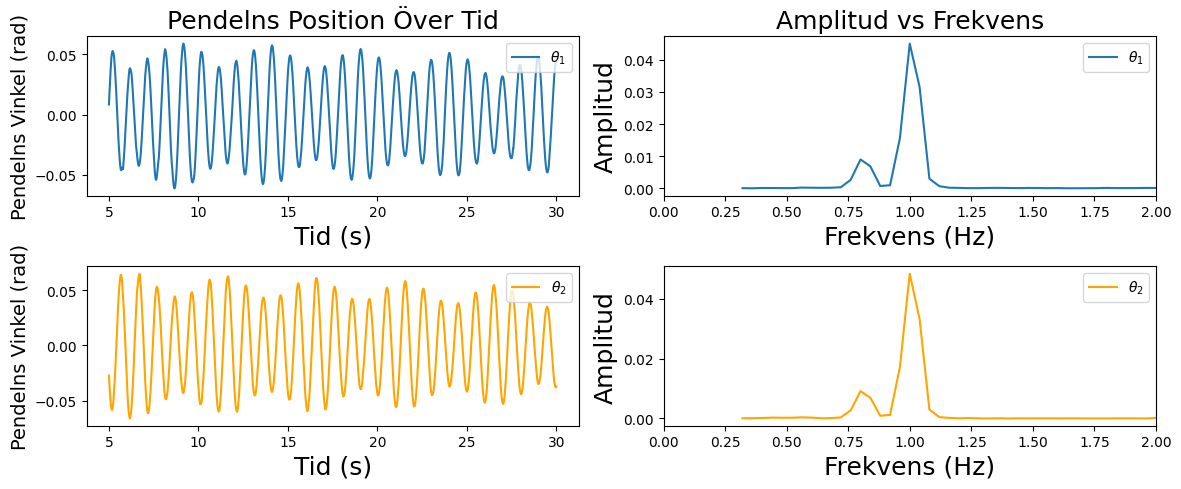

In [27]:
#massa 1.015 identiska, l=380 startade pendlar från teta1 = -theta2
plot_2("KS_motsvängning_m12.tsv",5, 30, 1.015, 380)

Dominerande frekvenser v1 [0.79968013 1.07956817]
Dominerande frekvenser v2 [0.79968013 1.07956817]
Dominerande amplituder [0.00206066 0.03914452]
Teoretiska frekvenser 0.8090662354024306 1.1331272645937607


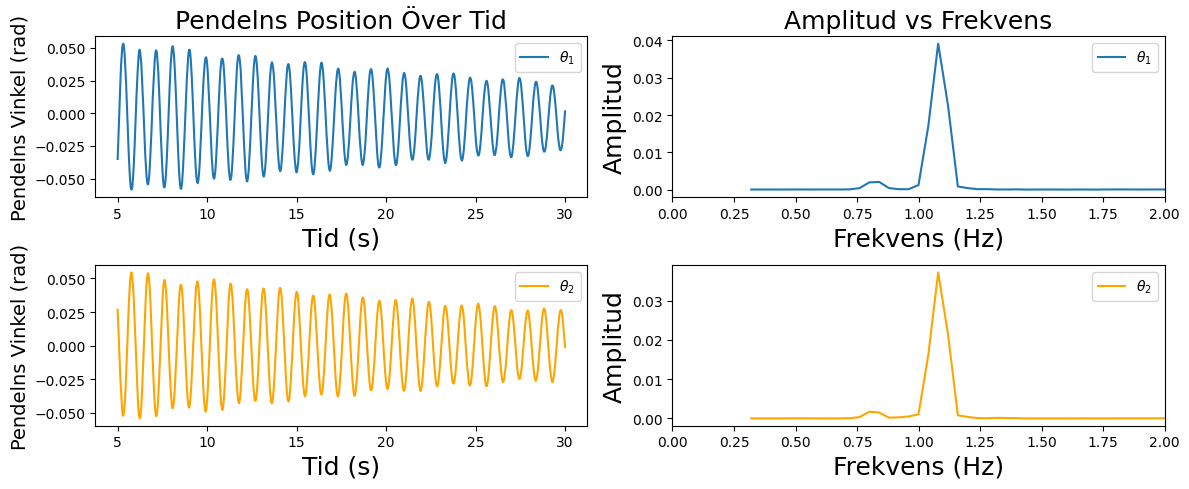

In [28]:
#motsvängning theta1=-theta2, massa m1 och m2, k = 12,614
plot_2("KF_FJ4_M12_Motsvängning.tsv",5, 30, 1.015, 380, 12.61)

Dominerande frekvenser v1 [1.07473132 0.79980005]
Dominerande frekvenser v2 [1.07473132 0.79980005]
Dominerande amplituder [0.03593176 0.04938309]
Teoretiska frekvenser 0.8090662354024306 1.1329070035243385


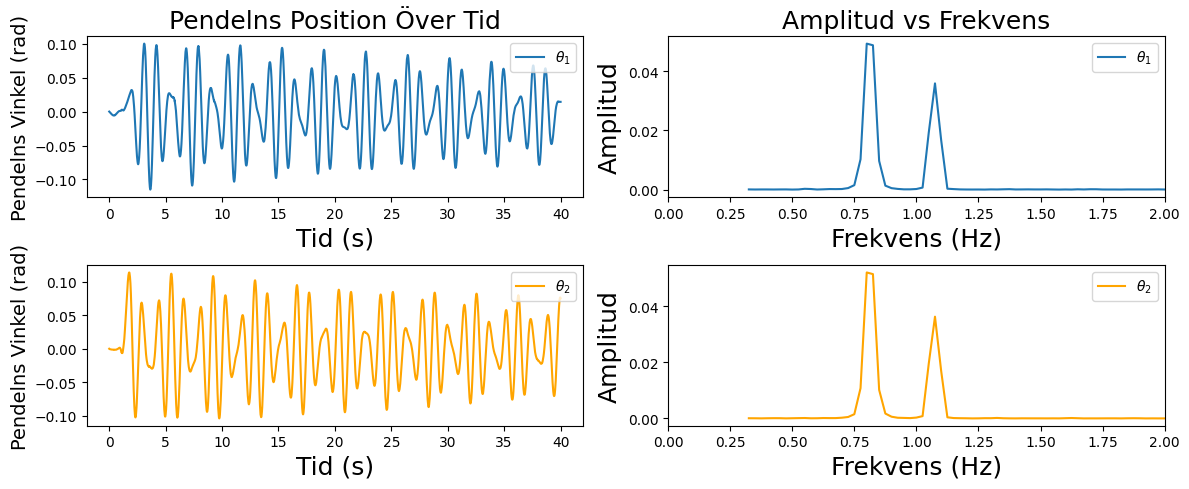

In [29]:
#theta1=ngt, theta2 = 0, massa m1 och m2, k = 16,614
plot_2("KS_Fj4_m12.tsv",0, 40, 1.015, 380, 12.6)

Dominerande frekvenser v1 [0.86087198 0.77756179]
Dominerande frekvenser v2 [0.86087198 0.77756179]
Dominerande amplituder [0.04728939 0.05363596]
Teoretiska frekvenser 0.7789040233965071 0.9007023081479328


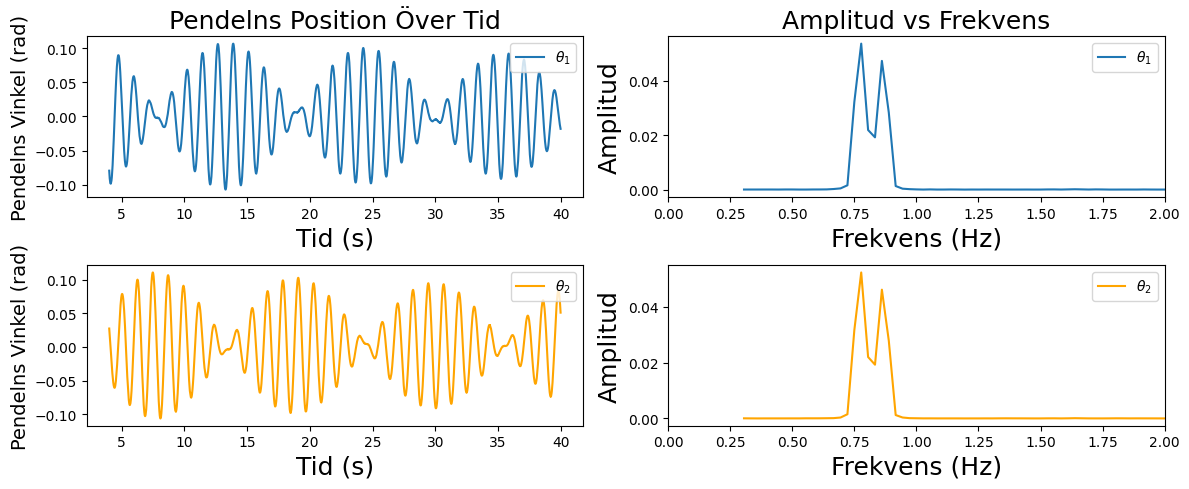

In [30]:

#dubbla massor 2.204, L = 38cm, ändra vinkel 1, masscentrum 41 cm
plot_2("Kopplade_svängnigar_samma_massor_variering/KF_FJ3_2M.tsv",4, 40, 2.204, 380, 8.9, 410)

Dominerande frekvenser v1 [0.91641211 0.80533185]
Dominerande frekvenser v2 [0.91641211 0.80533185]
Dominerande amplituder [0.04321529 0.05110591]
Teoretiska frekvenser 0.793555539667234 0.9656796340349535


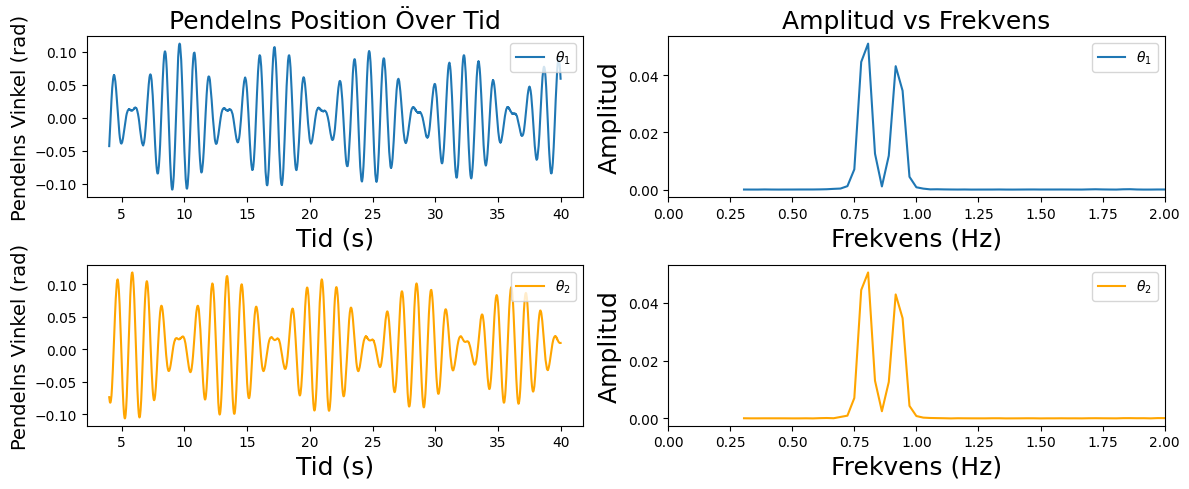

In [31]:
#m=1500, L = 38cm, ändra vinkel 1, m = 1.4898
plot_2("Kopplade_svängnigar_samma_massor_variering/FS_FJ3_m1500m1500.tsv",4, 40, 1.489, 380, 8.9, 395)

Dominerande frekvenser v1 [0.77394389 0.90293454]
Dominerande frekvenser v2 [0.77394389 0.90293454]
Dominerande amplituder [0.0458728  0.05483258]
Teoretiska frekvenser 0.7866161324974982 0.9400240698923593


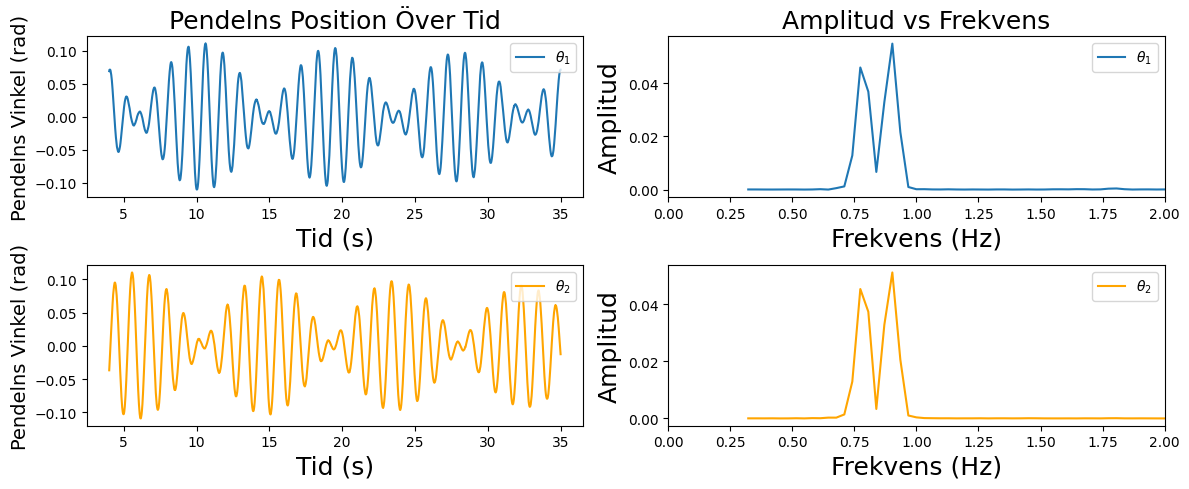

In [32]:
#m=1700, L = 38cm, ändra vinkel 1, m = 1.7022 medelvärdet av de två massorna
plot_2("Kopplade_svängnigar_samma_massor_variering/KF_Fj3_m1700m1700.tsv",4, 35, 1.7022, 380, 8.9, 402)

Dominerande frekvenser v1 [0.96742986 0.80619155]
Dominerande frekvenser v2 [0.96742986 0.80619155]
Dominerande amplituder [0.03411541 0.04217156]
Teoretiska frekvenser 0.8006819030688188 1.0039266680614094


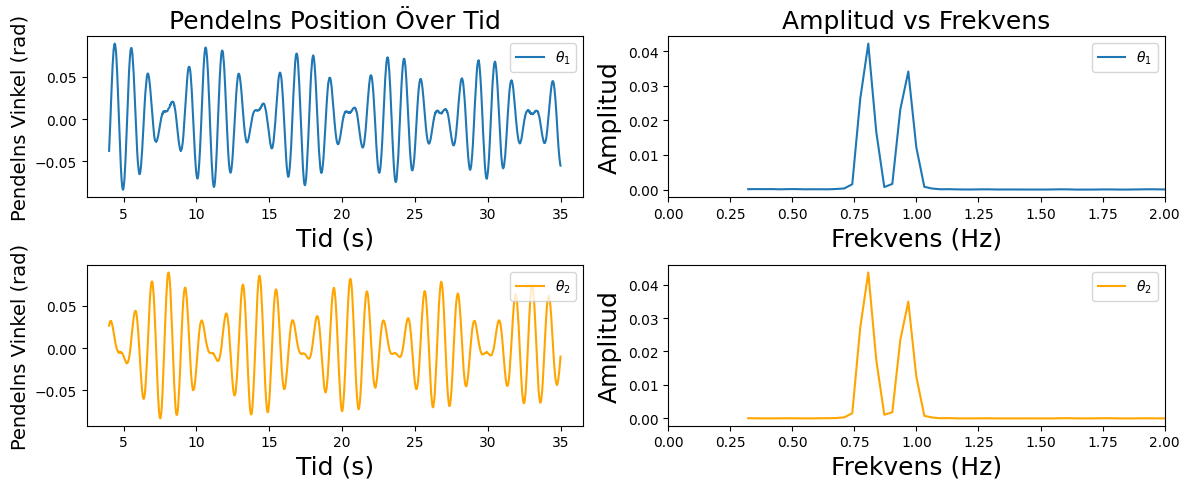

In [33]:
#m=1200, L = 38cm, ändra vinkel 1, m = 1.2293
plot_2("Kopplade_svängnigar_samma_massor_variering/KS_FJ3_m1200m1200.tsv",4, 35, 1.2293, 380, 8.9, 388)

Dominerande frekvenser v1 [0.90293454 0.6772009 ]
Dominerande frekvenser v2 [0.90293454 0.6772009 ]
Dominerande amplituder [0.0473779  0.07910883]
Teoretiska frekvenser 0.6818659196754444 0.9534973304740545


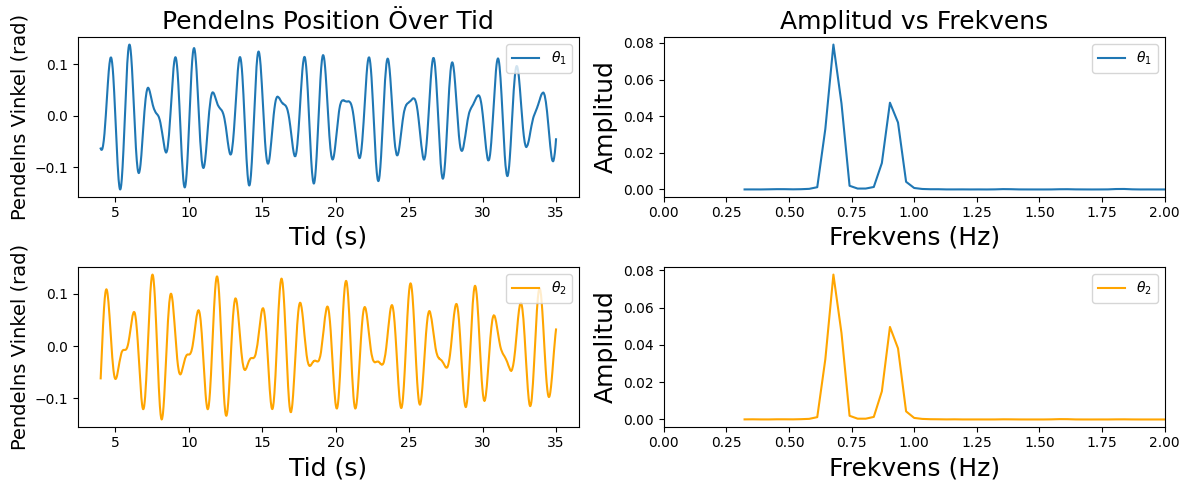

In [34]:
#m=1015, L = 53,5cm, 
plot_2("Kopplade_svängningar_längd_variering/KS_FJ3_m12_L53.tsv",4, 35, 1.015, 535)

Dominerande frekvenser v1 [0.83843921 1.03192519]
Dominerande frekvenser v2 [0.83843921 1.03192519]
Dominerande amplituder [0.04442122 0.04817132]
Teoretiska frekvenser 0.8491146383775692 1.0794497190297374


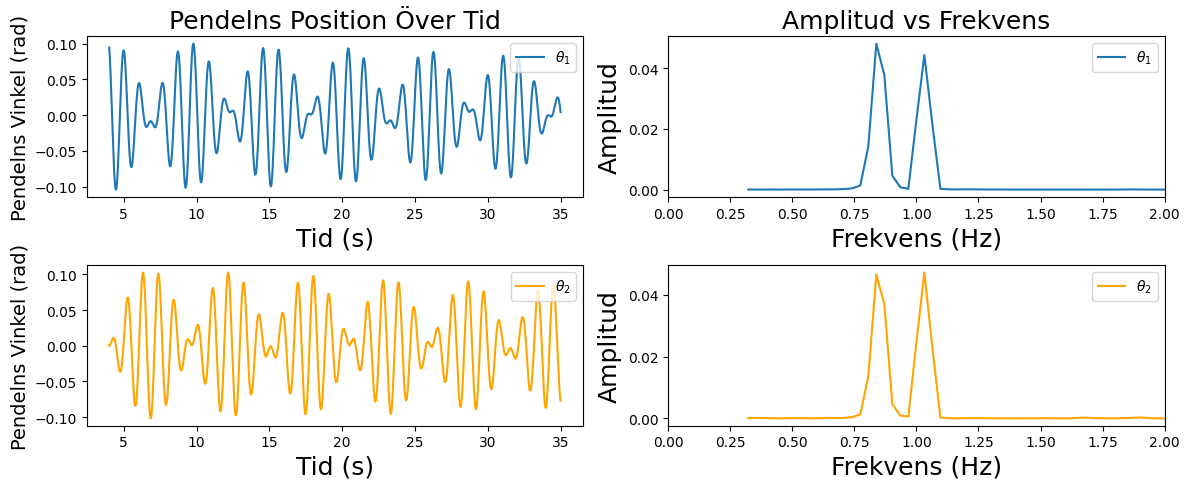

In [35]:
#m=1015, L = 34.5cm, 
plot_2("Kopplade_svängningar_längd_variering/KS_Fj3_m12_L34,5.tsv",4, 35, 1.015, 345)

Dominerande frekvenser v1 [0.90293454 0.6772009 ]
Dominerande frekvenser v2 [0.90293454 0.6772009 ]
Dominerande amplituder [0.03385171 0.03932039]
Teoretiska frekvenser 0.6664719287866563 0.9425501889379229


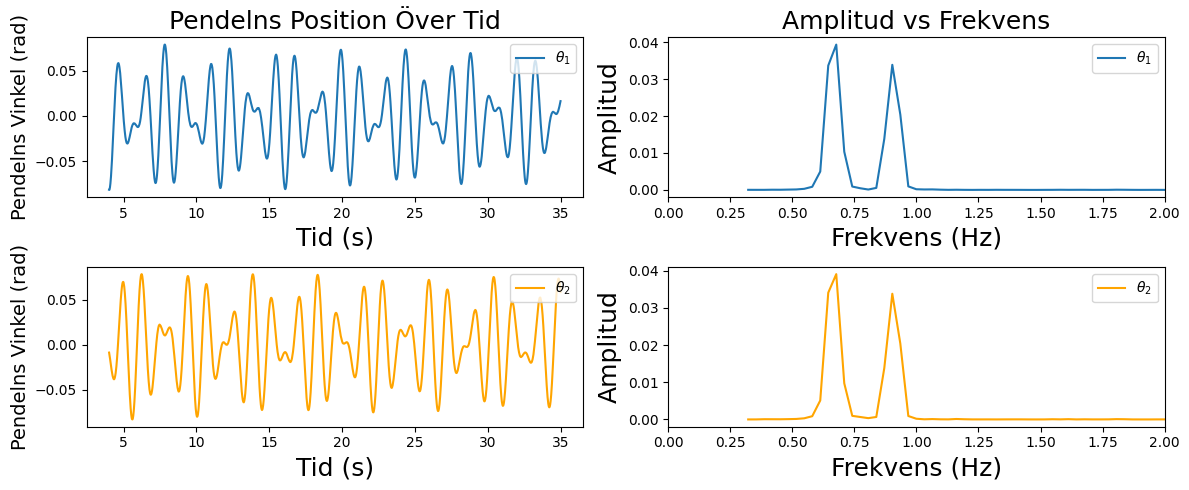

In [36]:
plot_2("Kopplade_svängningar_längd_variering/KS_FJ3_m12_L56,5.tsv",4, 35, 1.015, 560)

Dominerande frekvenser v1 [0.61270558 0.87068688]
Dominerande frekvenser v2 [0.61270558 0.87068688]
Dominerande amplituder [0.03059425 0.03098448]
Teoretiska frekvenser 0.6004147188015423 0.8970584492438849


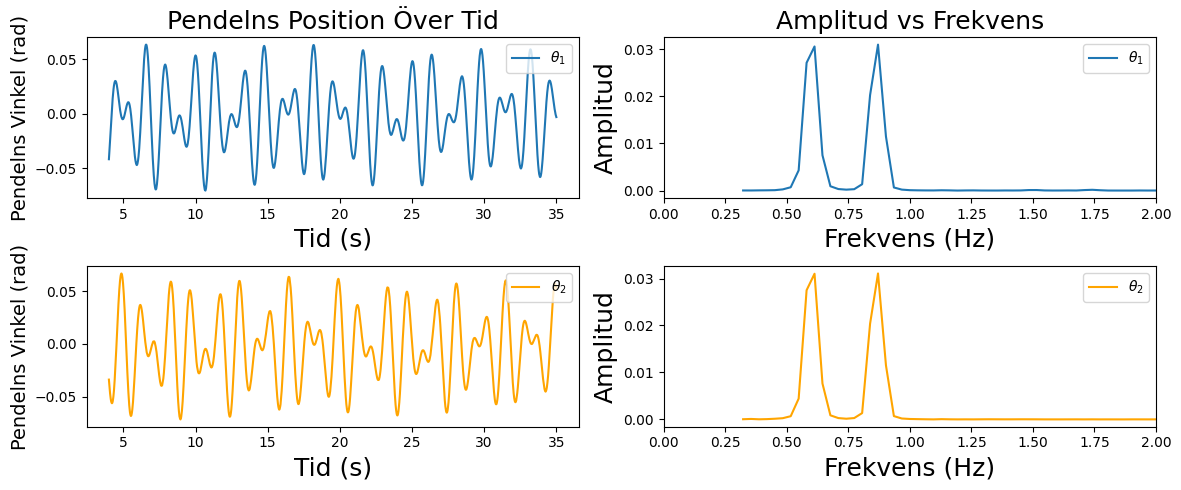

In [37]:
plot_2("Kopplade_svängningar_längd_variering/KS_Fj3_m12_L69.tsv",4, 35, 1.015, 690)

Dominerande frekvenser v1 [1.12866817 0.96742986]
Dominerande frekvenser v2 [1.12866817 0.96742986]
Dominerande amplituder [0.05655979 0.05833711]
Teoretiska frekvenser 0.9598292784964596 1.1685410864258658


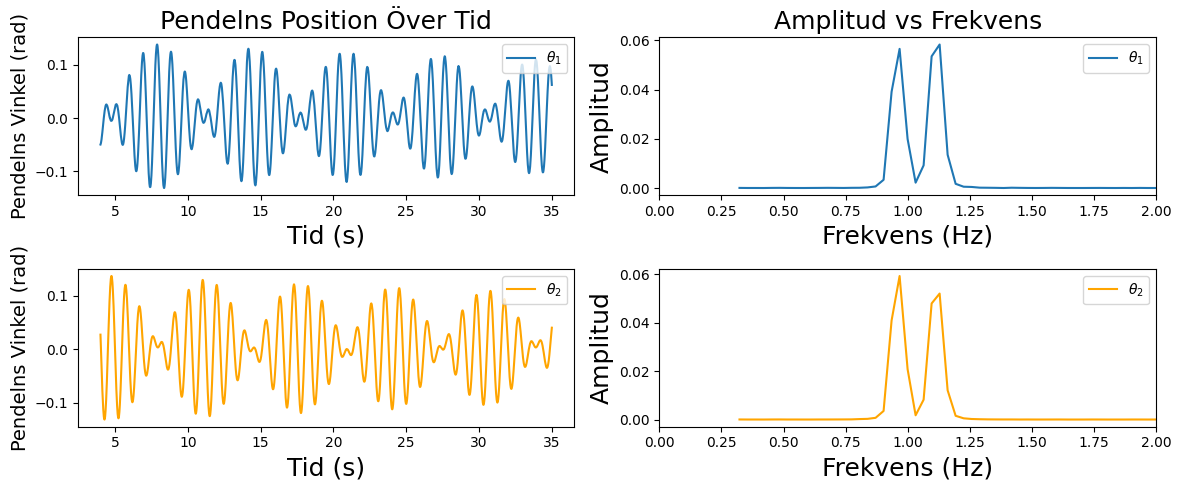

In [38]:
plot_2("Kopplade_svängningar_längd_variering/KS_FJ3_m12_L27.tsv",4, 35, 1.015, 270)